# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [65]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
# =============================================================================================

In [89]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [90]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [91]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [92]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [93]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [94]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [95]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted

<function sorted(iterable, /, *, key=None, reverse=False)>

In [96]:
#Deduplication of entries
temp_final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87773, 11)

In [97]:
#Sorting data according to Time in ascending order
final=temp_final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted

<function sorted(iterable, /, *, key=None, reverse=False)>

In [98]:

#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [99]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [101]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [116]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
#print(final.head)
#How many positive and negative reviews are present in our dataset?
print(final['Score'].value_counts())
y=final['Score']

(87773, 11)
1    73592
0    14181
Name: Score, dtype: int64


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [105]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!<br /><br />(For those wo

In [106]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [107]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!(For those wondering, this mix requ

In [108]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [109]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This gum is my absolute favorite. By purchasing on amazon I can get the savings of large quanities at a very good price. I highly recommend to all gum chewers. Plus as you enjoy the peppermint flavor and freshing of breath you are whitening your teeth all at the same time.


In [110]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [111]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This gum is my absolute favorite By purchasing on amazon I can get the savings of large quanities at a very good price I highly recommend to all gum chewers Plus as you enjoy the peppermint flavor and freshing of breath you are whitening your teeth all at the same time 


In [112]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [113]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    #sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
final['CleanedText'] = preprocessed_reviews
#final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#final['CleanedText'].shape

100%|██████████| 87773/87773 [00:37<00:00, 2311.03it/s]


In [87]:
#print(final.columns.values)
#preprocessed_reviews[1:4]
#print(final['Text'].head)
#print(final['CleanedText'].head)
print(final.columns.values)


['Id' 'ProductId' 'UserId' 'ProfileName' 'HelpfulnessNumerator'
 'HelpfulnessDenominator' 'Score' 'Time' 'Summary' 'Text' 'CleanedText']


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [142]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using absolute values of `coef_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

#Splitting into train and test data based on time

In [129]:
#Splitting 70% data into train set and 30 % as test set
train_set_temp,test_set= np.split(final, [int(.70 *len(final))])
#X_train, X_test, y_train, y_test = train_test_split(final, y, test_size=0.2)
print(train_set_temp.shape, test_set.shape)
#Splitting train set into train and cv set
train_set,cv_set = np.split(train_set_temp, [int(.50 *len(final))])
print(train_set.shape, cv_set.shape)
#Splitting train data into train and cv(60:20)
#X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.2)
#print(X_tr.shape, y_tr.shape)
#print(X_cv.shape, y_cv.shape)
y_tr=train_set['Score']
print(y_tr.shape)
y_cv=cv_set['Score']
print(y_cv.shape)
y_test=test_set['Score']
print(y_test.shape)

(61441, 11) (26332, 11)
(43886, 11) (17555, 11)
(43886,)
(17555,)
(26332,)


In [130]:
#Applying BoW
model = CountVectorizer()
model.fit(train_set['CleanedText'])
train_bow = model.transform(train_set['CleanedText'])
cv_bow = model.transform(cv_set['CleanedText'])
test_bow = model.transform(test_set['CleanedText'])
print(test_bow.shape)
print(cv_bow.shape)
print(train_bow.shape)

(26332, 39252)
(17555, 39252)
(43886, 39252)


<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [131]:
#Applying GridSearch to find the best hyperparameter alpha

alphas = np.array([0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000])
# create and fit a NB model, testing each alpha
#model = Ridge() 
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(class_prior=[0.5,0.5])
scoring = {'AUC': 'roc_auc'}
grid = GridSearchCV(estimator=clf, param_grid=dict(alpha=alphas),scoring = scoring, refit = 'AUC')
grid.fit(train_bow, y_tr)
print(grid)
# summarize the results of the grid search
(grid.best_score_)
print(grid.best_estimator_.alpha)
results_tr_bow = grid.cv_results_
#print(results_tr_bow)
#print(grid.confusion_matrix)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5],
                                     fit_prior=True),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit='AUC', return_train_score=False,
             scoring={'AUC': 'roc_auc'}, verbose=0)
1.0


alpha value =  1
Area under the ROC curve : %f 0.90867665750292
[[ 2295   812]
 [ 1062 13386]]


Text(0.5, 15.0, 'Predicted label')

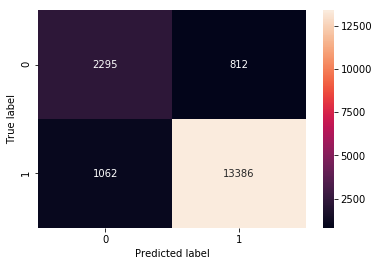

In [132]:
# After finding the best hyperparameter value for BOW which is 1, applying naive bayes on train dataset and predicting
# accuracy/AUC score for cv dataset
from sklearn.naive_bayes import MultinomialNB
#alphas = np.array([0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
clf = MultinomialNB(alpha = 1, class_prior=[0.5,0.5])
#clf.fit(train_bow,y_tr)
cclf=clf.fit(train_bow, y_tr).predict(cv_bow)
pred_cv = clf.predict_proba(cv_bow)[:,1]
print('alpha value = ',1)
fpr, tpr, thresholds = roc_curve(y_cv,pred_cv)
roc_auc_cv = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_cv)

#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_cv, cclf)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')


alpha value =  1
Area under the ROC curve : %f 0.9085480381553013
[[ 3336  1221]
 [ 1595 20180]]


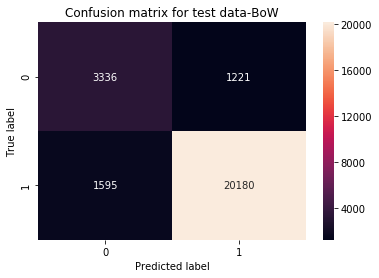

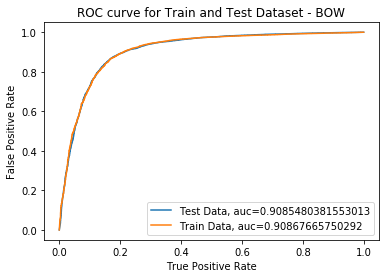

In [133]:
# After finding the best hyperparameter value for BOW which is 1, applying naive bayes on train dataset and predicting
# accuracy/AUC score for cv dataset
from sklearn.naive_bayes import MultinomialNB
#alphas = np.array([0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
clf = MultinomialNB(alpha = 1, class_prior=[0.5,0.5])
#clf.fit(train_bow,y_tr)
cclf=clf.fit(train_bow, y_tr).predict(test_bow)
pred_test = clf.predict_proba(test_bow)[:,1]
print('alpha value = ',1)
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_test = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_test)

#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, cclf)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for test data-BoW')

#Plot ROC Curve
plt.figure(0).clf()
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_test = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Test Data, auc="+str(roc_auc_test))

fpr, tpr, thresh = roc_curve(y_cv, pred_cv)
roc_auc_cv = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Train Data, auc="+str(roc_auc_cv))
plt.title('ROC curve for Train and Test Dataset - BOW')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.legend(loc=0)


### [5.1.1] Top 10 important features of positive/negative class from<font color='red'> SET 1</font>

In [134]:
#Finding the top 20 features in BOW:
import matplotlib.pyplot as plt

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    feature_names = np.array(feature_names)
    print("Positive coefficients:",feature_names[top_positive_coefficients])
    print("Negative coefficients:",feature_names[top_negative_coefficients])

plot_coefficients(clf, model.get_feature_names(), top_features=20)

Positive coefficients: ['was' 'as' 'they' 'but' 'with' 'you' 'are' 'that' 'have' 'my' 'not' 'in'
 'for' 'this' 'of' 'to' 'it' 'is' 'and' 'the']
Negative coefficients: ['contaminating' 'waaaaay' 'believers' 'hausbrandt' 'believewhat'
 'popovers' 'poplite' 'chessie' 'poper' 'havedoes' 'havegetarian'
 'havenot' 'poorely' 'muchhh' 'chery' 'darjeelings' 'pooing' 'cherryheads'
 'haveto' 'snadwich']


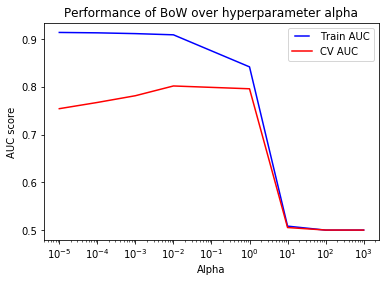

In [135]:
#Performance of BoW over hyperparameter alpha
alpha = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
train_results = []
test_results = []
for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(train_bow, y_tr)
    train_pred = clf.predict(train_bow)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_tr, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = clf.predict(cv_bow)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_cv, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
ax = plt.gca()
ax.set_xscale('log')
line1, = ax.plot(alpha, train_results, 'b', label="Train AUC")
line2, = ax.plot(alpha, test_results, 'r', label="CV AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title("Performance of BoW over hyperparameter alpha")
plt.ylabel('AUC score')
plt.xlabel('Alpha')
plt.show()

Observation:
    
    The graph shows that for best alpha value of 1, the AUC score for train and test data is 0.84 and 0.8 respectively.
    As alpha increases, AUC score decreases to 0.5.
   

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [137]:
#Applying tf_idf vectorization
tf_idf_vec = TfidfVectorizer(ngram_range=(1,2))
tf_idf_vec.fit(train_set['Text'])
train_tf_idf = tf_idf_vec.transform(train_set['Text'])
test_tf_idf = tf_idf_vec.transform(test_set['Text'])
cv_tf_idf = tf_idf_vec.transform(cv_set['Text'])

print(test_tf_idf.shape)
print(train_tf_idf.shape)
print(cv_tf_idf.shape)

(26332, 717931)
(43886, 717931)
(17555, 717931)


In [134]:
## [5.2] Applying Gridsearch to find best hyperparameter value on TFIDF,<font color='red'> SET 2</font>

In [138]:
alphas = np.array([0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000])
# create and fit a NB model, testing each alpha
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
clsf = MultinomialNB(class_prior=[0.5,0.5])
scoring = {'AUC': 'roc_auc'}
grid = GridSearchCV(estimator=clsf, param_grid=dict(alpha=alphas),scoring = scoring, refit = 'AUC')
grid.fit(train_tf_idf, y_tr)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)
results_tfidf = grid.cv_results_
#print(results_tfidf)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5],
                                     fit_prior=True),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit='AUC', return_train_score=False,
             scoring={'AUC': 'roc_auc'}, verbose=0)
0.9223090948575503
0.01


alpha value =  0.01
Area under the ROC curve : %f 0.9446221197553055
[[ 2111   996]
 [  485 13963]]


Text(0.5, 15.0, 'Predicted label')

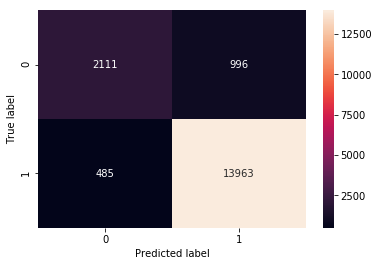

In [139]:
# After finding the best hyperparameter value for tfidf which is 0.01, applying naive bayes on train dataset and predicting
# accuracy/AUC score for cv dataset
from sklearn.naive_bayes import MultinomialNB
#alphas = np.array([0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
clf = MultinomialNB(alpha = 0.01, class_prior=[0.5,0.5])
#clf.fit(train_bow,y_tr)
cclf=clf.fit(train_tf_idf, y_tr).predict(cv_tf_idf)
pred_cv = clf.predict_proba(cv_tf_idf)[:,1]
print('alpha value = ',0.01)
fpr, tpr, thresholds = roc_curve(y_cv,pred_cv)
roc_auc_cv = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_cv)

#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_cv, cclf)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')


alpha value =  0.01
Area under the ROC curve : %f 0.9455822724630758
[[ 3019  1538]
 [  679 21096]]


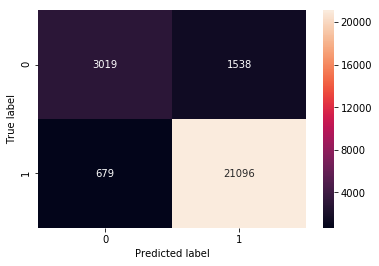

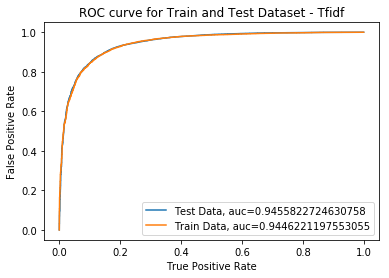

In [140]:
# After finding the best hyperparameter value for Tfidf which is 0.01, applying naive bayes on train dataset and predicting
# accuracy/AUC score for test dataset
from sklearn.naive_bayes import MultinomialNB
#alphas = np.array([0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
clf = MultinomialNB(alpha = 0.01, class_prior=[0.5,0.5])
#clf.fit(train_bow,y_tr)
cclf=clf.fit(train_tf_idf, y_tr).predict(test_tf_idf)
pred_test = clf.predict_proba(test_tf_idf)[:,1]
print('alpha value = ',0.01)
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_test = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_test)

#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, cclf)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Plot ROC Curve
plt.figure(0).clf()
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_test = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Test Data, auc="+str(roc_auc_test))

fpr, tpr, thresh = roc_curve(y_cv, pred_cv)
roc_auc_cv = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Train Data, auc="+str(roc_auc_cv))
plt.title('ROC curve for Train and Test Dataset - Tfidf')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.legend(loc=0)


In [141]:
plot_coefficients(clf, tf_idf_vec.get_feature_names(), top_features=20)

Positive coefficients: ['them' 'but' 'these' 'with' 'have' 'they' 'that' 'are' 'you' 'my' 'in'
 'for' 'this' 'of' 'br' 'is' 'to' 'it' 'and' 'the']
Negative coefficients: ['rate as' 'no direct' 'bad facsimile' 'bad expired' 'pick kona'
 'seller buyer' 'bad experiance' 'seller cares' 'bad everything' 'no dirt'
 'demonstrated how' 'bad ethoxyquin' 'seller checked' 'seller claims'
 'demonstrates failure' 'demonstrates the' 'no did' 'to orville'
 'denied however' 'bad even']


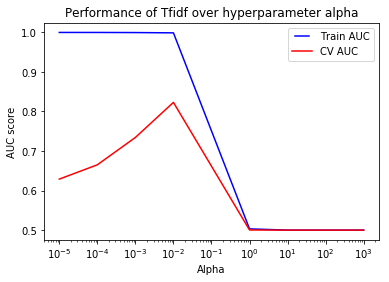

In [142]:
#Performance of BoW over hyperparameter alpha
alpha = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
train_results = []
test_results = []
for i in alpha:
    clf = MultinomialNB(alpha=i,class_prior=[0.5,0.5])
    clf.fit(train_tf_idf, y_tr)
    train_pred = clf.predict(train_tf_idf)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_tr, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = clf.predict(cv_tf_idf)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_cv, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
ax = plt.gca()
ax.set_xscale('log')
line1, = ax.plot(alpha, train_results, 'b', label="Train AUC")
line2, = ax.plot(alpha, test_results, 'r', label="CV AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title("Performance of Tfidf over hyperparameter alpha")
plt.ylabel('AUC score')
plt.xlabel('Alpha')
plt.show()

Observation:
    
    The graph shows that for best alpha value of 0.01, the AUC score for train and test data is 0.98 and 0.74 respectively.
    As alpha increases, AUC score decreases to 0.5

# [6] Conclusions

In [143]:
# Please compare all your models using Prettytable library

print("Performance results for random splitted data")

from prettytable import PrettyTable
table = PrettyTable(["model","alpha value","Train AUC","Test AUC"])
table.add_row(["Naive Bayes using BoW", "1",0.9169,0.9171])
table.add_row(["Naives Bayes using TFIDF","0.01",0.954,0.954])
print(table)

print("Performance results for time based splitted data")

table = PrettyTable(["model","alpha value","Train AUC","Test AUC"])
table.add_row(["Naive Bayes using BoW", "1",0.908,0.908])
table.add_row(["Naives Bayes using TFIDF","0.01",0.945,0.945])
print(table)

Performance results for random splitted data
+--------------------------+-------------+-----------+----------+
|          model           | alpha value | Train AUC | Test AUC |
+--------------------------+-------------+-----------+----------+
|  Naive Bayes using BoW   |      1      |   0.9169  |  0.9171  |
| Naives Bayes using TFIDF |     0.01    |   0.954   |  0.954   |
+--------------------------+-------------+-----------+----------+
Performance results for time based splitted data
+--------------------------+-------------+-----------+----------+
|          model           | alpha value | Train AUC | Test AUC |
+--------------------------+-------------+-----------+----------+
|  Naive Bayes using BoW   |      1      |   0.908   |  0.908   |
| Naives Bayes using TFIDF |     0.01    |   0.945   |  0.945   |
+--------------------------+-------------+-----------+----------+


Observation:
    1. Upon comparing AUC score for random based and time based splitted data, they are almost the same.
    2. By seeing the confusion matrix, random based data predicts the positive and negative class with less error than the latter.
    3. But, the top positive and negative features are more meaningful in time based splitted data.